In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get tag-to-salt data frame
if nu.pickle_exists('tag_to_salt_df'):
    tag_to_salt_df = nu.load_object('tag_to_salt_df')
    print(tag_to_salt_df.shape)
    # df = tag_to_salt_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 110)



# Triage Accuracy

(How many patients did they get right and do they do it in the right order, for example: still or obvious life threat first (Red, Gray, Black), then wavers, then walkers last.)


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/salt_mass_casualty_triage.png" />


### Correct Count

In [18]:

# Get the total and correct counts for each run
rows_list = []
groupby_columns = ['session_uuid', 'time_group']
for (session_uuid, time_group), df in tag_to_salt_df.groupby(groupby_columns):
    
    # Add the logger version and the groupby columns to the row dictionary
    row_dict = {}
    row_dict['logger_version'] = df.logger_version.unique().item()
    for cn in groupby_columns: row_dict[cn] = eval(cn)

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    row_dict['correct_count'] = correct_count
    total_count = df.patient_count.sum()
    row_dict['total_count'] = total_count
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Create the correct count data frame
correct_count_df = pd.DataFrame(rows_list)

In [19]:

correct_count_df

,logger_version,session_uuid,time_group,correct_count,total_count,percentage_tag_correct
0,1.3,009b848c-ea64-4f22-bd40-711213a3d327,1,0,10,0.000000
1,1.3,009b848c-ea64-4f22-bd40-711213a3d327,2,7,11,63.636364
2,1.0,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,0,0,3,0.000000
3,1.0,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,1,3,12,25.000000
4,1.0,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,2,9,11,81.818182
...,...,...,...,...,...,...
1063,1.0,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,1,4,12,33.333333
1064,1.0,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,2,11,11,100.000000
1065,1.3,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,0,4,0.000000
1066,1.3,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,1,3,12,25.000000


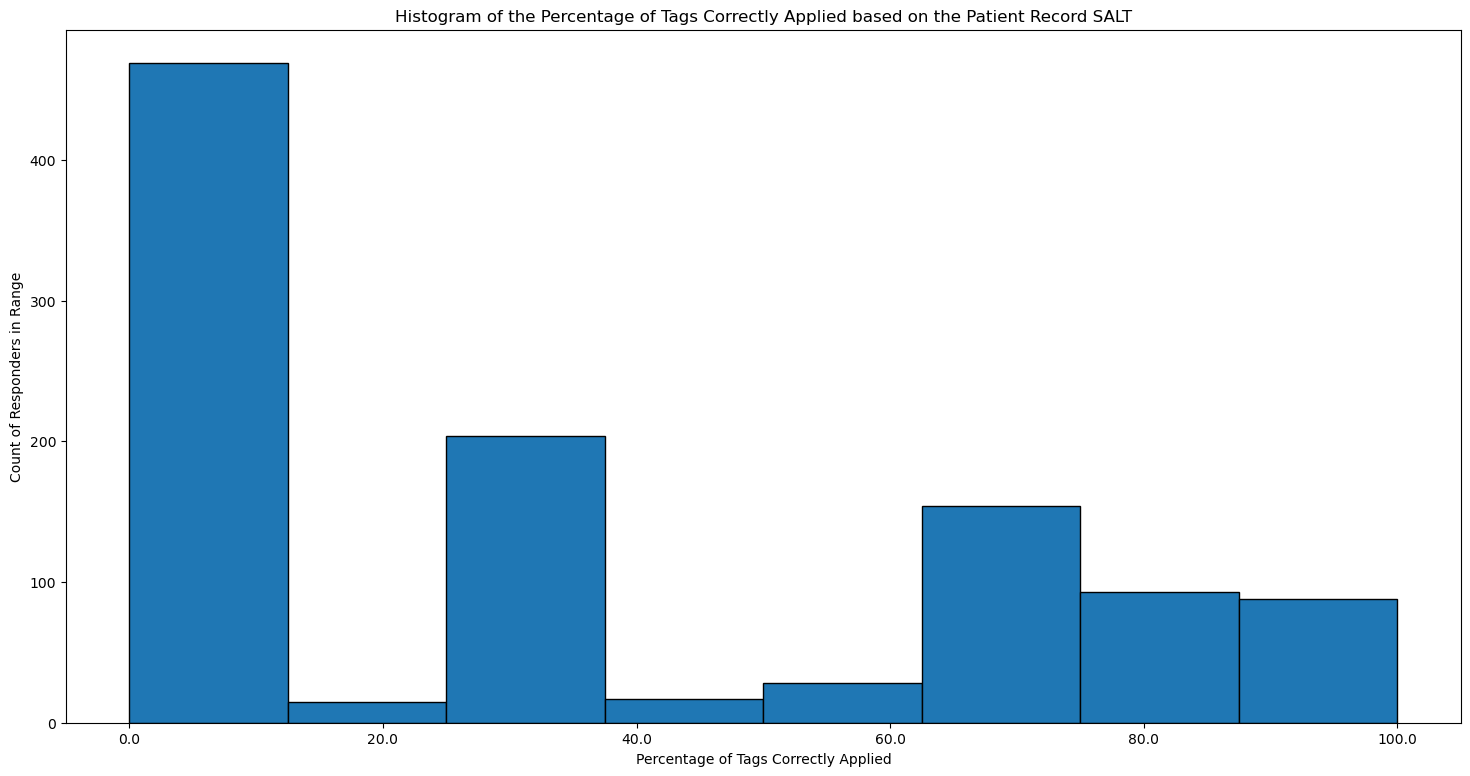

In [20]:

# Display a histogram of the percentage of tags correctly applied based on the patient record SALT
xlabel = 'Percentage of Tags Correctly Applied'
get_xtick_text = lambda text_obj: round(text_obj.get_position()[0], 2)
title = 'Histogram of the Percentage of Tags Correctly Applied based on the Patient Record SALT'
ylabel = 'Count of Responders in Range'
ax = nu.plot_histogram(correct_count_df, 'percentage_tag_correct', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=False, bins=8)

In [21]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
columns_list = [
    'correct_count', 'total_count', 'percentage_tag_correct'
]
df = correct_count_df[columns_list]
display(nu.get_statistics(columns_list, df).applymap(lambda x: round(x, 2), na_action='ignore').T)

,mean,mode,median,SD,min,25%,50%,75%,max
correct_count,3.72,0.0,4.00,3.80,0.0,0.0,4.00,8.00,13.0
total_count,9.25,11.0,11.00,3.52,1.0,8.0,11.00,11.00,26.0
percentage_tag_correct,33.37,0.0,33.33,34.52,0.0,0.0,33.33,67.86,100.0



## How many responders correctly tagged all patients? Should be a percentage of all responders

In [44]:

total_count = correct_count_df.total_count.sum()
correct_count = correct_count_df.correct_count.sum()
percentage_tag_correct = 100*correct_count/total_count
print(f'{percentage_tag_correct:.2f}% of all responders correctly tagged all patients.')

40.19% of all responders correctly tagged all patients.
